# Marketing Campaign A/B Testing - Proportion
Company A has recently identified that the click-through rate (CTR) of a display banner is performing below the established benchmark. In an effort to address this issue, they are interested in exploring whether the implementation of a new creative featuring an attention-grabbing call-out could potentially enhance the click-through rate. Could you develop an experiment to address this challenge?

In [1]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install statsmodels



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.stats.power import ttest_power, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats

C:\Users\Bessie Xu\AppData\Local\Temp\ipykernel_21780\3031232317.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# upload dataset
pretest = pd.read_csv("d:\Studying\AB Testing\XHS AB testing\AB Testing Practice Proportion Dataset\pretest.csv")

C:\Users\Bessie Xu\AppData\Local\Temp\ipykernel_21780\3394205138.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pretest = pd.read_csv("d:\Studying\AB Testing\XHS AB testing\AB Testing Practice Proportion Dataset\pretest.csv")


In [4]:
print(pretest)

        impression_id    date experiment  group  clicked  spend
0                   1  6/1/23        NaN    NaN        0  0.005
1                   2  6/1/23        NaN    NaN        0  0.005
2                   3  6/1/23        NaN    NaN        0  0.005
3                   4  6/1/23        NaN    NaN        0  0.005
4                   5  6/1/23        NaN    NaN        0  0.005
...               ...     ...        ...    ...      ...    ...
309898         309899  7/1/23        NaN    NaN        1  0.005
309899         309900  7/1/23    AA_test    0.0        0  0.005
309900         309901  7/1/23        NaN    NaN        0  0.005
309901         309902  7/1/23        NaN    NaN        0  0.005
309902         309903  7/1/23        NaN    NaN        0  0.005

[309903 rows x 6 columns]


# 1. power analysis

In [5]:
# calculate sample size for the test
# 1. mean & std
pretest['date']=pd.to_datetime(pretest['date'])

avg_CTR = pretest.clicked.mean()
print("CTR: ", avg_CTR.round(4))

avg_CPM = pretest.spend.sum()/pretest.impression_id.count()
print("Average CPM: ", avg_CPM.round(4))

C:\Users\Bessie Xu\AppData\Local\Temp\ipykernel_21780\3313573401.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pretest['date']=pd.to_datetime(pretest['date'])


CTR:  0.101
Average CPM:  0.005


In [6]:
# 2.effect size & input parameters
MDE = 0.1 ## empirical threshold
significance_level = 0.05
power = 0.8
effect_size = sm.stats.proportion_effectsize(avg_CTR, avg_CTR*(1+MDE))

# calculate for equal sample size
sample_size = tt_ind_solve_power(effect_size=effect_size,
                                 alpha = significance_level,
                                 power = power,
                                 ratio = 1,
                                 alternative='two-sided',
                                 nobs1= None)

print("sample size need for each group: " + str(sample_size))
print("sample size needed for the test: " + str(sample_size*2))

sample size need for each group: 14584.67432047729
sample size needed for the test: 29169.34864095458


# 2. Test Duration

In [7]:
# group by date, and count unique impression_id
daily_unique_imp = pretest.groupby('date')['impression_id'].nunique()
# avg daily impression count
avg_daily_unique_imp = daily_unique_imp.mean()
# test duration base on sample size
test_duration = sample_size*2/avg_daily_unique_imp
print("Based on the last month data, the average daily impression is: ", avg_daily_unique_imp)
print("Baed on the last month data, the test duration would better to be: ", test_duration)

Based on the last month data, the average daily impression is:  9996.870967741936
Baed on the last month data, the test duration would better to be:  2.9178478681058007


In [8]:
# Optimize the test duration to be a full week
ajusted_test_duration = math.ceil(test_duration/7)*7
print("The ajusted test duration would be: ", ajusted_test_duration)

The ajusted test duration would be:  7


# 3. Budget

In [9]:
# linear estimation, budget = sample size * cost per impression
total_spend_budget = sample_size *2 * avg_CPM
daily_spend_budget = total_spend_budget/ajusted_test_duration

print("Total test budget would be: ", f'{total_spend_budget:.2f}')
print("Daily spend budget would be: ", f'{daily_spend_budget:.2f}')

Total test budget would be:  145.85
Daily spend budget would be:  20.84


# 4. Validity Test 
-AA test
-SRM test(sample ratio mismatch)
-Novelty Effect

In [10]:
# 1. AA test (is there any big diff in CTR between control & treatment group? )
AA_test = pretest[pretest.experiment == 'AA_test']
# control group 0, treat group 1
AA_control = AA_test[AA_test.group == 0]['clicked']
AA_treatment = AA_test[AA_test.group == 1]['clicked']

AA_control_cnt = AA_control.sum()
AA_control_rate = AA_control.mean()
AA_control_size = AA_control.count()

AA_treatment_cnt = AA_treatment.sum()
AA_treatment_rate = AA_treatment.mean()
AA_treatment_size = AA_treatment.count()

print("-------- AA test --------")
print(f'Control group CTR: {AA_control_rate:.3}')
print(f'Treatment group CTR: {AA_treatment_rate:.3}')

-------- AA test --------
Control group CTR: 0.101
Treatment group CTR: 0.0988


In [11]:
# Chi-squared test: compaing proportions in categorical data
# statsmodels.stats.proportion: proportion_chisquare function
AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs=[AA_control_size, AA_treatment_size])

first_date = AA_test['date'].min().date()
last_date = AA_test['date'].max().date()

AA_alpha = 0.05

print(f'--------- AA test ({first_date} - {last_date})--------\n')
print('H0: The CTR between 2 creatives are the same.')
print('Ha: The CTR between 2 creatives are different. \n')
print(f'Chi-square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\nConclusion:')
if AA_pvalue < AA_alpha:
    print('Reject H0, there is statistical significance between the two groups. Check for instrumentation errors')
else:
    print('Fail to reject H0. Proceed with the AB test')


--------- AA test (2023-06-18 - 2023-07-01)--------

H0: The CTR between 2 creatives are the same.
Ha: The CTR between 2 creatives are different. 

Chi-square = 0.577 | P-value = 0.448

Conclusion:
Fail to reject H0. Proceed with the AB test


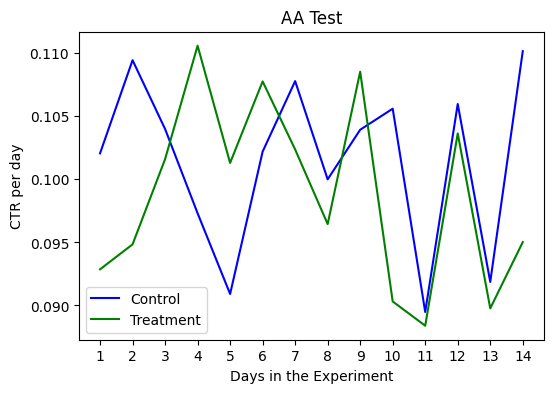

In [12]:
# Avg sales per user per day:
AA_CTR_per_day = AA_test.groupby(['group','date'])['clicked'].mean()
AA_control_ctr = AA_CTR_per_day.loc[0]
AA_treatment_ctr = AA_CTR_per_day.loc[1]

# day range
exp_day = range(1, AA_test['date'].nunique()+1)

f, ax = plt.subplots(figsize = (6,4))
ax.plot(exp_day, AA_control_ctr, label ='Control', color = 'b')
ax.plot(exp_day, AA_treatment_ctr, label = "Treatment", color = 'g')

ax.set_xticks(exp_day)
ax.set_title('AA Test')
ax.set_ylabel('CTR per day')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

In [13]:
# 2. SRM test (sample ratio mismatch)
#(check the test result data)
test_result = pd.read_csv("d:\\Studying\\AB Testing\\XHS AB testing\\AB Testing Practice Proportion Dataset\\test.csv")

test_result.info()
test_result.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69961 entries, 0 to 69960
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   impression_id  69961 non-null  int64 
 1   date           69961 non-null  object
 2   experiment     15055 non-null  object
 3   group          69961 non-null  int64 
 4   clicked        69961 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.7+ MB


,impression_id,group,clicked
count,69961.000000,69961.000000,69961.000000
mean,34981.000000,0.498192,0.104901
std,20196.145428,0.500000,0.306428
min,1.000000,0.000000,0.000000
25%,17491.000000,0.000000,0.000000
50%,34981.000000,0.000000,0.000000
75%,52471.000000,1.000000,0.000000
max,69961.000000,1.000000,1.000000


In [14]:
# use the package: import scipy.stats as stats
SRM_alpha = 0.05

creative_test = test_result[test_result.experiment == 'creative_test']
observed = creative_test.groupby('group')['experiment'].count().values
expected = [creative_test.shape[0]*0.5]*2

print('Obervered counts: ', observed)
print('Expected counts: ', expected)

# chi-square to test goodness of fit test
chi_stats, pvalue = stats.chisquare(f_obs=observed, f_exp=expected)
print(f'-------- Chi-square test for SRM -------\n')
print('H0: the ratio of sample is around 1:1.')
print('Ha: the ratio of sample is not 1:1.\n')
print(f'Significance level: {SRM_alpha}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {pvalue:.3f}')

print(f'\nConclusion:')
if pvalue < SRM_alpha:
    print('Reject H0 and conclude that there is statistical significance in the ratio of samples not being 1:1.There is SRM(sample ratio mismatch)')
else:
    print('Fail to reject H0, no SRM, proceed with the AB test')


Obervered counts:  [7463 7592]
Expected counts:  [7527.5, 7527.5]
-------- Chi-square test for SRM -------

H0: the ratio of sample is around 1:1.
Ha: the ratio of sample is not 1:1.

Significance level: 0.05
Chi-Square = 1.105 | P-value = 0.293

Conclusion:
Fail to reject H0, no SRM, proceed with the AB test


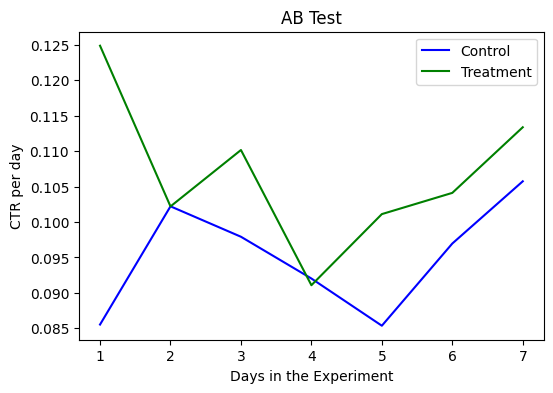

In [15]:
# 3. Novelty Effect
# testresult avg sales per user per day:
AB_ctr_per_day = creative_test.groupby(['group','date'])['clicked'].mean()
AB_control_ctr = AB_ctr_per_day.loc[0]
AB_treat_ctr = AB_ctr_per_day.loc[1]
# day range
exp_days = range(1, creative_test['date'].nunique()+1)

f, ax = plt.subplots(figsize = (6,4))
ax.plot(exp_days, AB_control_ctr, label="Control", color='b')
ax.plot(exp_days, AB_treat_ctr, label="Treatment", color='g')

ax.set_xticks(exp_days)
ax.set_title('AB Test')
ax.set_ylabel('CTR per day')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

# 5. Conduct Statistical Inference

In [16]:
# subset tables of control and treatment group
control_clicks = creative_test[creative_test.group == 0]['clicked']
treatment_clicks = creative_test[creative_test.group == 1]['clicked']

# get statistics
AB_control_cnt = control_clicks.sum()
AB_control_rate = control_clicks.mean()
AB_control_size = control_clicks.count()

AB_treatment_cnt = treatment_clicks.sum()
AB_treatment_rate = treatment_clicks.mean()
AB_treatment_size = treatment_clicks.count()

# Calculation
print(f'Control CTR: {AB_control_rate:.4}')
print(f'Treatment CTR: {AB_treatment_rate:.4}')


Control CTR: 0.09527
Treatment CTR: 0.1067


In [17]:
# T-test for CTR
AB_alpha = 0.05

AB_tstat, AB_pvalue, AB_df = ttest_ind(treatment_clicks, control_clicks)

first_date = creative_test['date'].min()
last_date = creative_test['date'].max()

print(f'-------- AB Test CTR ({first_date} - {last_date})--------\n')
print('H0: The CTR between two creatives are the same')
print('Ha: THe CTR between two creatives differenct. \n')

print(f'T-statistic = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_alpha:
    print('Reject H0 and conclude that there is statistical significance in the diff of CTR between 2 creatives.')
else:
    print('Fail to reject H0')   

-------- AB Test CTR (8/1/23 - 8/7/23)--------

H0: The CTR between two creatives are the same
Ha: THe CTR between two creatives differenct. 

T-statistic = 2.325 | P-value = 0.020

Conclusion:
Reject H0 and conclude that there is statistical significance in the diff of CTR between 2 creatives.


In [19]:
# Create two descriptive statistics objects using test and control data
desc_stats_test = sm.stats.DescrStatsW(treatment_clicks)
desc_stats_control = sm.stats.DescrStatsW(control_clicks)

# compare the means
cm = sms.CompareMeans(desc_stats_test, desc_stats_control)

# Calculate the CI for the diff between the means (unequal variances)
lb, ub = cm.tconfint_diff(usevar = 'unequal')

print(f'Confidence Interval: ({lb:.3f}, {ub:.3f})')

# Calculate lift between test and control
lower_lift = lb/AB_control_rate
upper_lift = ub/AB_control_rate

print(f'Confidence Interval for lift: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')


Confidence Interval: (0.002, 0.021)
Confidence Interval for lift: (1.9%, 22.1%)


In [21]:
# CI for the test
ci = confint_proportions_2indep(AB_treatment_cnt, AB_treatment_size, AB_control_cnt, AB_control_size, method = None, compare='diff', alpha = 0.05, correction = True)
lower = ci[0]
upper = ci[1]
lower_lift = ci[0]/AB_control_rate
upper_lift = ci[0]/AB_control_rate

In [ ]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- CTR ----------')
print(f'Control: {AB_control_cnt} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_cnt} ({AB_treatment_rate*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}')
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')